# ProfessionAI - Face detection
## Specifiche
Devi fornire una pipeline scikit-learn che prende un'immagine in ingresso e ritorna una lista con le coordinate dei bounding box dove sono presenti dei volti, se nell'immagine non contiene volti la lista sarà ovviamente vuota.

# Moduli

In [ ]:
# Librerie standard
import os
from io import BytesIO

# Elaborazione numerica e delle immagini
import numpy as np
import cv2
from skimage import io, color, feature, transform, util

# Machine learning
from sklearn import datasets, utils, model_selection, svm, pipeline, preprocessing, metrics, ensemble
from joblib import Parallel, delayed

# Deep learning
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor, Grayscale, Resize

# Visualizzazione
import matplotlib.pyplot as plt

# Gestione dei file e integrazione con Google Colab
import zipfile
from google.colab import drive, files
from google.colab.patches import cv2_imshow

# Classi e funzioni specifiche
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.feature as hog_feature # Import the hog function
from skimage.feature import local_binary_pattern
from sklearn.pipeline import Pipeline


import joblib

#Costanti

In [ ]:
REGION_SIZE = (64, 64)
STEP_SIZE = 32

# Connessione a google drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1 - Costruzione del Dataset per il Riconoscimento Facciale
In questo progetto, ho costruito un dataset per il riconoscimento facciale unendo differenti dataset.

Il processo è iniziato con l'utilizzo del dataset BioID, contenente immagini di volti. Ho estratto queste immagini e le relative annotazioni direttamente in memoria da un file zip.

Successivamente, ho elaborato le immagini isolando i volti utilizzando i punti chiave forniti e ridimensionandoli a una dimensione uniforme (64 x 64).
Per completare il dataset iniziale, che conteneva solo esempi positivi, ho integrato esempi di "non-volti".

A questo scopo, ho selezionato immagini dal dataset STL-10 che non contenevano volti. Queste immagini sono state convertite in scala di grigi e ridimensionate, sempre in formato 64 x 64, per corrispondere alle dimensioni delle immagini dei volti. Per caricare questa libreria ho utilizzato la libreria `torchvision`.

Il passaggio finale ha comportato la combinazione di questi due set di dati: le immagini di volti e quelle di non-volti sono state unite in un unico dataset. Ho etichettato le immagini dei volti con '1' e quelle dei non-volti con '0', creando così un dataset bilanciato e strutturato.

## Url datasets
- BioID: https://drive.google.com/file/d/1Xtr8j7YkubB7AvxETDIB8Ea4xqB2ETsK/view?usp=sharing

- STL-10: https://cs.stanford.edu/~acoates/stl10/

In [ ]:
def extract_zip_in_memory(zip_path):
    """
    Estrae i file da un archivio zip in memoria e li organizza in due dizionari.

    Args:
        zip_path (str): Percorso del file zip.

    Returns:
        tuple: Due dizionari contenenti rispettivamente le immagini e le annotazioni.
    """
    images = {}
    annotations = {}
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            with zip_ref.open(file) as f:
                if file.startswith('BioID/images/') and file.endswith('.pgm'):
                    images[file.replace('BioID/images/', '')] = f.read()
                elif file.startswith('BioID/annotations/') and file.endswith('.pts'):
                    annotations[file.replace('BioID/annotations/', '')] = f.read()
    return images, annotations

def load_pts_from_bytes(file_bytes):
    """
    Carica i punti chiave da un file .pts in memoria.

    Args:
        file_bytes (bytes): Contenuto del file .pts in formato bytes.

    Returns:
        numpy.ndarray: Array di punti chiave.
    """
    lines = file_bytes.decode('utf-8').splitlines()[3:-1]
    points = []
    for line in lines:
        x, y = line.strip().split()
        points.append((int(float(x)), int(float(y))))
    return np.array(points)

def get_bounding_box(landmarks):
    """
    Calcola la bounding box dati i punti chiave del volto.

    Args:
        landmarks (numpy.ndarray): Array di punti chiave.

    Returns:
        tuple: Coordinate della bounding box (x_min, y_min, x_max, y_max).
    """
    x_min = np.min(landmarks[:, 0])
    x_max = np.max(landmarks[:, 0])
    y_min = np.min(landmarks[:, 1])
    y_max = np.max(landmarks[:, 1])
    return (x_min, y_min, x_max, y_max)

def isolate_and_resize_face(image, landmarks, size=REGION_SIZE):
    """
    Isola il volto utilizzando le annotazioni BioID e ridimensiona l'immagine.

    Args:
        image (numpy.ndarray): Immagine originale.
        landmarks (numpy.ndarray): Array di punti chiave.
        size (tuple): Dimensioni desiderate per l'immagine ridimensionata.

    Returns:
        numpy.ndarray: Immagine del volto isolato e ridimensionato, o None se non valida.
    """
    x_min = np.min(landmarks[:, 0])
    x_max = np.max(landmarks[:, 0])
    y_min = np.min(landmarks[:, 1])
    y_max = np.max(landmarks[:, 1])

    # Check if bounding box is valid before extracting face
    if x_min >= x_max or y_min >= y_max:
        print("Invalid bounding box. Skipping face extraction.")
        return None

    face_image = image[y_min:y_max, x_min:x_max]

    # Check if face image is empty before resizing
    if face_image.size == 0:
        print("Empty face image encountered. Skipping resizing.")
        return None

    resized_face_image = cv2.resize(face_image, size)
    return resized_face_image

def process_bioid_dataset(images, annotations, size=REGION_SIZE):
    """
    Elabora tutte le immagini del dataset BioID in memoria.

    Args:
        images (dict): Dizionario contenente le immagini in formato bytes.
        annotations (dict): Dizionario contenente le annotazioni in formato bytes.
        size (tuple): Dimensioni desiderate per le immagini elaborate.

    Returns:
        tuple: Array X contenente le immagini elaborate e array y contenente le etichette.
    """
    print(annotations.keys())
    X = []
    y = []
    for image_name, image_bytes in images.items():
        pts_name = image_name.replace('.pgm', '.pts').lower()
        if pts_name in annotations:
            # Carica l'immagine e i punti chiave dai bytes
            image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
            if image is not None:
                landmarks_bytes = annotations[pts_name]
                landmarks = load_pts_from_bytes(landmarks_bytes)

                # Isola e ridimensiona il volto
                face_image = isolate_and_resize_face(image, landmarks, size)

                # Check if face was extracted successfully
                if face_image is not None:
                    # Aggiungi l'immagine del volto a X e 1 a y
                    X.append(face_image)
                    y.append(1)
            else:
                print(f"Errore nel caricamento dell'immagine: {image_name}")
    return np.array(X), np.array(y)


def load_non_face_images_stl10(size=REGION_SIZE, random_seed=None):
    """
    Carica un massimo di 1000 immagini non contenenti volti dal dataset STL-10.

    Args:
        size (tuple): Dimensioni desiderate per le immagini caricate.
        random_seed (int): Seed per la generazione di numeri casuali.

    Returns:
        tuple: Array di immagini non-volto e array di etichette corrispondenti.
    """
    # Carica il dataset STL-10
    dataset = STL10(root='./data', split='train', download=True, transform=ToTensor())

    # Imposta il seed casuale
    if random_seed is not None:
        np.random.seed(random_seed)

    non_face_images = []
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label not in [0, 1]:  # Supponendo che le classi 0 e 1 siano volti, cambia se necessario
            img = Grayscale()(img)
            img = Resize(size)(img)
            non_face_images.append(img.numpy().squeeze())

    # Creare le etichette
    labels = [0] * len(non_face_images)
    return np.array(non_face_images), np.array(labels)

def create_combined_dataset(bioid_zip_path, size=REGION_SIZE, max_non_face_samples=1500, random_seed=None):
    """
    Crea un dataset combinato con immagini di volti e non-volti.

    Args:
        bioid_zip_path (str): Percorso del file zip contenente il dataset BioID.
        size (tuple): Dimensioni desiderate per le immagini elaborate.
        max_non_face_samples (int): Numero massimo di campioni non-volto da includere.
        random_seed (int): Seed per la generazione di numeri casuali.

    Returns:
        tuple: Array X contenente tutte le immagini e array y contenente le etichette corrispondenti.
    """
    images, annotations = extract_zip_in_memory(bioid_zip_path)

    X_faces, y_faces = process_bioid_dataset(images, annotations, size)
    X_non_faces, y_non_faces = load_non_face_images_stl10(size, random_seed=random_seed)

    # Combina i dati
    X = np.concatenate((X_faces, X_non_faces), axis=0)
    y = np.concatenate((y_faces, y_non_faces), axis=0)

    # Shuffle the dataset
    X, y = shuffle(X, y, random_state=random_seed)

    return X, y

bioid_zip_path = '/content/drive/MyDrive/Dataset/ProfessionAI/BioID.zip'
X, y = create_combined_dataset(bioid_zip_path, random_seed=42)

print("Dataset creato con successo")
print(f"Forma di X: {X.shape}")
print(f"Forma di y: {y.shape}")


dict_keys(['bioid_0000.pts', 'bioid_0001.pts', 'bioid_0002.pts', 'bioid_0003.pts', 'bioid_0004.pts', 'bioid_0005.pts', 'bioid_0006.pts', 'bioid_0007.pts', 'bioid_0008.pts', 'bioid_0009.pts', 'bioid_0010.pts', 'bioid_0011.pts', 'bioid_0012.pts', 'bioid_0013.pts', 'bioid_0014.pts', 'bioid_0015.pts', 'bioid_0016.pts', 'bioid_0017.pts', 'bioid_0018.pts', 'bioid_0019.pts', 'bioid_0020.pts', 'bioid_0021.pts', 'bioid_0022.pts', 'bioid_0023.pts', 'bioid_0024.pts', 'bioid_0025.pts', 'bioid_0026.pts', 'bioid_0027.pts', 'bioid_0028.pts', 'bioid_0029.pts', 'bioid_0030.pts', 'bioid_0031.pts', 'bioid_0032.pts', 'bioid_0033.pts', 'bioid_0034.pts', 'bioid_0035.pts', 'bioid_0036.pts', 'bioid_0037.pts', 'bioid_0038.pts', 'bioid_0039.pts', 'bioid_0040.pts', 'bioid_0041.pts', 'bioid_0042.pts', 'bioid_0043.pts', 'bioid_0044.pts', 'bioid_0045.pts', 'bioid_0046.pts', 'bioid_0047.pts', 'bioid_0048.pts', 'bioid_0049.pts', 'bioid_0050.pts', 'bioid_0051.pts', 'bioid_0052.pts', 'bioid_0053.pts', 'bioid_0054.pts',

100%|██████████| 2640397119/2640397119 [03:03<00:00, 14421587.57it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Dataset creato con successo
Forma di X: (5519, 64, 64)
Forma di y: (5519,)


# Step 2 - Estrazione feature per addestramento
Per l'estrazione delle feature ho deciso di usare una combinazione di caratteristiche HOG (Histogram of Oriented Gradients) e LBP (Local Binary Patterns). La classe `FeatureExtractor` è stata progettata per sfruttare queste due tecniche, combinandole per estrarre feature dalle immagini.

### Descrizione combinazione feature

#### Histogram of Oriented Gradients (HOG)
Le feature HOG sono ideali per catturare i contorni e le strutture principali nelle immagini, concentrandosi sui gradienti di intensità. Questa tecnica è particolarmente utile per il riconoscimento facciale perché:
- **Robustezza ai cambiamenti di illuminazione:** I gradienti rimangono relativamente invariati rispetto alle variazioni di luce.
- **Cattura delle forme:** Le feature HOG descrivono bene i bordi e le forme, che sono essenziali per distinguere i volti dagli altri oggetti.

#### Local Binary Patterns (LBP)
Le feature LBP sono utilizzate per catturare le texture locali nelle immagini, trasformando ogni pixel in un valore binario basato sui pixel circostanti. Questo approccio è vantaggioso perché:
- **Descrizione delle texture:** LBP è efficace nel caratterizzare le texture fini.
- **Computazionalmente efficiente:** Il calcolo delle feature LBP è veloce e richiede meno risorse rispetto ad altre tecniche di texture.

### Vantaggi della combinazione
La combinazione di HOG e LBP offre una serie di vantaggi, sfruttando i punti di forza di entrambe le tecniche:
- **Complementarità:** HOG e LBP catturano diversi aspetti delle immagini: HOG si concentra sui gradienti e sulle forme, mentre LBP si focalizza sulle texture locali.

### Approccio Generale
L'approccio generale consiste nel preparare l'estrattore (`fit`), anche se in questo caso non c'è molto da preparare, e poi utilizzare il metodo `transform` per estrarre le feature HOG e LBP da ogni immagine. Le regioni di interesse vengono analizzate individualmente per estrarre queste feature combinate, che vengono poi concatenate per formare una rappresentazione unica della regione. Questo processo è reso efficiente attraverso la parallelizzazione, che riduce i tempi di elaborazione.

### Fonti

https://www.quora.com/What-is-the-difference-between-HOG-and-LBP

http://arxiv.org/pdf/1805.05837

https://medium.com/@danyang95luck/comparison-of-hog-histogram-of-oriented-gradients-and-sift-scale-invariant-feature-transform-e2b17f61c9a3


In [ ]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
      A class for extracting combined HOG and LBP features from images.

      This class is designed to work with scikit-learn's pipeline, inheriting from
      BaseEstimator and TransformerMixin. It extracts Histogram of Oriented Gradients (HOG)
      and Local Binary Pattern (LBP) features from image regions.

      Methods:
      --------
      fit(X, y=None):
          Fits the extractor to the data (in this case, it's a no-op).
      transform(X):
          Transforms the input data by extracting features from each image.
      extract_combined_features(image, regions=None, n_jobs=-1):
          Extracts combined features from specified regions of an image.
      extract_combined_features_single(region):
          Extracts combined HOG and LBP features from a single region.
      extract_lbp_features(region):
          Extracts LBP features from a region.
      extract_hog_features(region):
          Extracts HOG features from a region.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        all_features = []
        for img, orig_size, resized_size, regions in X:
            adjusted_regions = [(x, y, img[y:y + h, x:x + w]) for x, y, w, h in regions]
            features = self.extract_combined_features(img, adjusted_regions)
            all_features.append((features, regions, orig_size, resized_size))
        return all_features

    def extract_combined_features(self, image, regions=None, n_jobs=-1):
        if regions is None:
            regions = [(0, 0, image)]

        combined_features = Parallel(n_jobs=n_jobs)(
            delayed(self.extract_combined_features_single)(region) for (x, y, region) in regions
        )
        return combined_features

    def extract_combined_features_single(self, region):
        hog_features = self.extract_hog_features(region)
        lbp_features = self.extract_lbp_features(region)
        combined = np.hstack((hog_features, lbp_features))
        return combined

    def extract_lbp_features(self, region):
        if region.ndim == 3:
            region = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

        lbp = local_binary_pattern(region, P=24, R=3, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        return hist

    def extract_hog_features(self, region):
        # Ensure the region is grayscale
        if region.ndim == 3:
            region = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

        # Resize region to a consistent size for HOG
        region = cv2.resize(region, (64, 64))  # Adjust the size as needed

        features, _ = hog_feature.hog(region, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        return features





#Step 3 - Addrestramento del modello

## Divisione del Dataset
Abbiamo diviso il dataset in training e test usando train_test_split, con il 20% dei dati riservato per il test. La stratificazione è stata usata per mantenere le proporzioni delle classi in entrambe le suddivisioni, garantendo che il modello non sia influenzato da sbilanciamenti tra le classi.

## Estrazione delle Feature
Il FeatureExtractor combina HOG e LBP per ogni immagine. Ogni immagine viene ridimensionata a 64x64 pixel, e le feature vengono estratte da questa dimensione uniforme. Questo passaggio è cruciale per garantire la coerenza delle feature tra tutte le immagini.

## Preparazione dei Dati
Le feature estratte vengono concatenate e trasformate in array NumPy, pronti per l'addestramento del modello. Questo passaggio di concatenazione assicura che tutte le feature siano organizzate in un formato che il classificatore SVM possa processare efficacemente.

## Addestramento del Classificatore
Ho scelto un SVM con kernel lineare per la sua efficacia nei problemi di classificazione facciale. L'uso di C=0.1 e gamma='scale' sono stati trovati tramite la ricerca GridSearchCV con vari parametri, così come il kernel linear.

Con questo stralcio di codice:


```
param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto']
}

# Grid Search con cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_features, y_train)
```



Il parametro probability=True permette di ottenere probabilità predittive, utile per applicazioni future come l'analisi della fiducia nelle previsioni.

In [ ]:
# Assumiamo che X contenga le immagini originali e y le etichette

# Dividiamo il dataset in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

feature_extractor = FeatureExtractor()

# Prepariamo i dati per l'estrazione delle feature
X_train_prepared = [(img, (64, 64), (64, 64), [(0, 0, 64, 64)]) for img in X_train]
X_test_prepared = [(img, (64, 64), (64, 64), [(0, 0, 64, 64)]) for img in X_test]

# Estraiamo le feature
X_train_features = feature_extractor.fit_transform(X_train_prepared)
X_test_features = feature_extractor.transform(X_test_prepared)

# Prepariamo i dati per l'addestramento
X_train_prepared = np.vstack([features for features, _, _, _ in X_train_features])
X_test_prepared = np.vstack([features for features, _, _, _ in X_test_features])

# Stampiamo le forme per debug
print(f"Forma di X_train_prepared: {X_train_prepared.shape}")
print(f"Forma di X_test_prepared: {X_test_prepared.shape}")


Forma di X_train_prepared: (4415, 1790)
Forma di X_test_prepared: (1104, 1790)


In [ ]:
# Addestriamo il classificatore
classifier = SVC(C=0.1, gamma='scale', kernel='linear', probability = True)
classifier.fit(X_train_prepared, y_train)

# Valutiamo le performance
accuracy = classifier.score(X_test_prepared, y_test)
print(f"Accuratezza sul set di test: {accuracy}")

Accuratezza sul set di test: 0.9990942028985508


# Step 4 - Creazione pipeline

#### Pre-processamento delle Immagini

La classe `ImagePreprocessor` ottimizza le immagini per l'analisi successiva:

- Ridimensiona le immagini mantenendo le proporzioni originali
- Converte le immagini in scala di grigi

Questo processo è fondamentale per:

1. Uniformare le dimensioni delle immagini in input
2. Ridurre la complessità computazionale
3. Eliminare variazioni di colore non essenziali
4. Preparare le immagini per l'applicazione efficiente delle finestre scorrevoli

#### Rilevamento delle Regioni con Finestre Scorrevoli

La classe `PyramidRegionDetector` implementa un approccio a piramide utilizzando finestre scorrevoli:

1. Creazione della piramide di immagini:
   - L'immagine originale viene ridimensionata progressivamente, creando una "piramide" di immagini a diverse scale.
   - Ogni livello della piramide rappresenta l'immagine a una risoluzione inferiore.

2. Applicazione delle finestre scorrevoli:
   - Per ogni livello della piramide, una finestra di dimensione fissa "scorre" sull'immagine.
   - La finestra si sposta tipicamente con un passo predefinito (stride) sia orizzontalmente che verticalmente.

3. Vantaggi delle finestre scorrevoli:
   - Permettono di analizzare sistematicamente ogni parte dell'immagine.
   - Consentono il rilevamento di oggetti a diverse scale senza dover ridimensionare la finestra stessa.
   - Aumentano la robustezza del rilevamento, catturando oggetti di diverse dimensioni e posizioni.

4. Ottimizzazioni:
   - L'uso di stride variabili può bilanciare la velocità di elaborazione e l'accuratezza del rilevamento.
   - Tecniche come l'integral image possono accelerare i calcoli all'interno delle finestre.

5. Gestione delle sovrapposizioni:
   - Le finestre scorrevoli spesso producono rilevamenti sovrapposti.
   - Tecniche come la Non-Maximum Suppression (NMS) vengono impiegate per unire o eliminare rilevamenti ridondanti.

#### Estrazione delle Feature

Il `FeatureExtractor` combina:

- **HOG (Histogram of Oriented Gradients)**: Cattura informazioni sui bordi e le forme, particolarmente utili per definire la struttura del volto.
- **LBP (Local Binary Patterns)**: Descrive le texture locali, efficace per catturare dettagli come rughe o caratteristiche della pelle.

#### Rilevamento dei Volti

La classe `FaceDetector` utilizza un SVM (Support Vector Machine) pre-addestrato:

- L'SVM classifica le regioni estratte dalle finestre scorrevoli come "volto" o "non volto".
- La normalizzazione delle feature non è stata utilizzata in quanto dopo alcuni test i risultati si dimostravano alterati.

#### Regolazione delle Regioni Rilevate

La classe `FaceAdjuster` perfeziona i risultati:

- Aggiunge padding alle regioni rilevate per includere il contesto circostante.
- Assicura che le regioni rientrino nei limiti dell'immagine originale, evitando artefatti ai bordi.
- Può implementare tecniche di fusione per gestire rilevamenti multipli dello stesso volto.


L'approccio delle finestre scorrevoli, combinato con la piramide di immagini, forma il cuore di questo sistema di rilevamento dei volti, permettendo un'analisi dettagliata e multi-scala dell'immagine. Questa tecnica, sebbene computazionalmente intensiva, offre robustezza e flessibilità nel rilevamento di oggetti di varie dimensioni e posizioni.

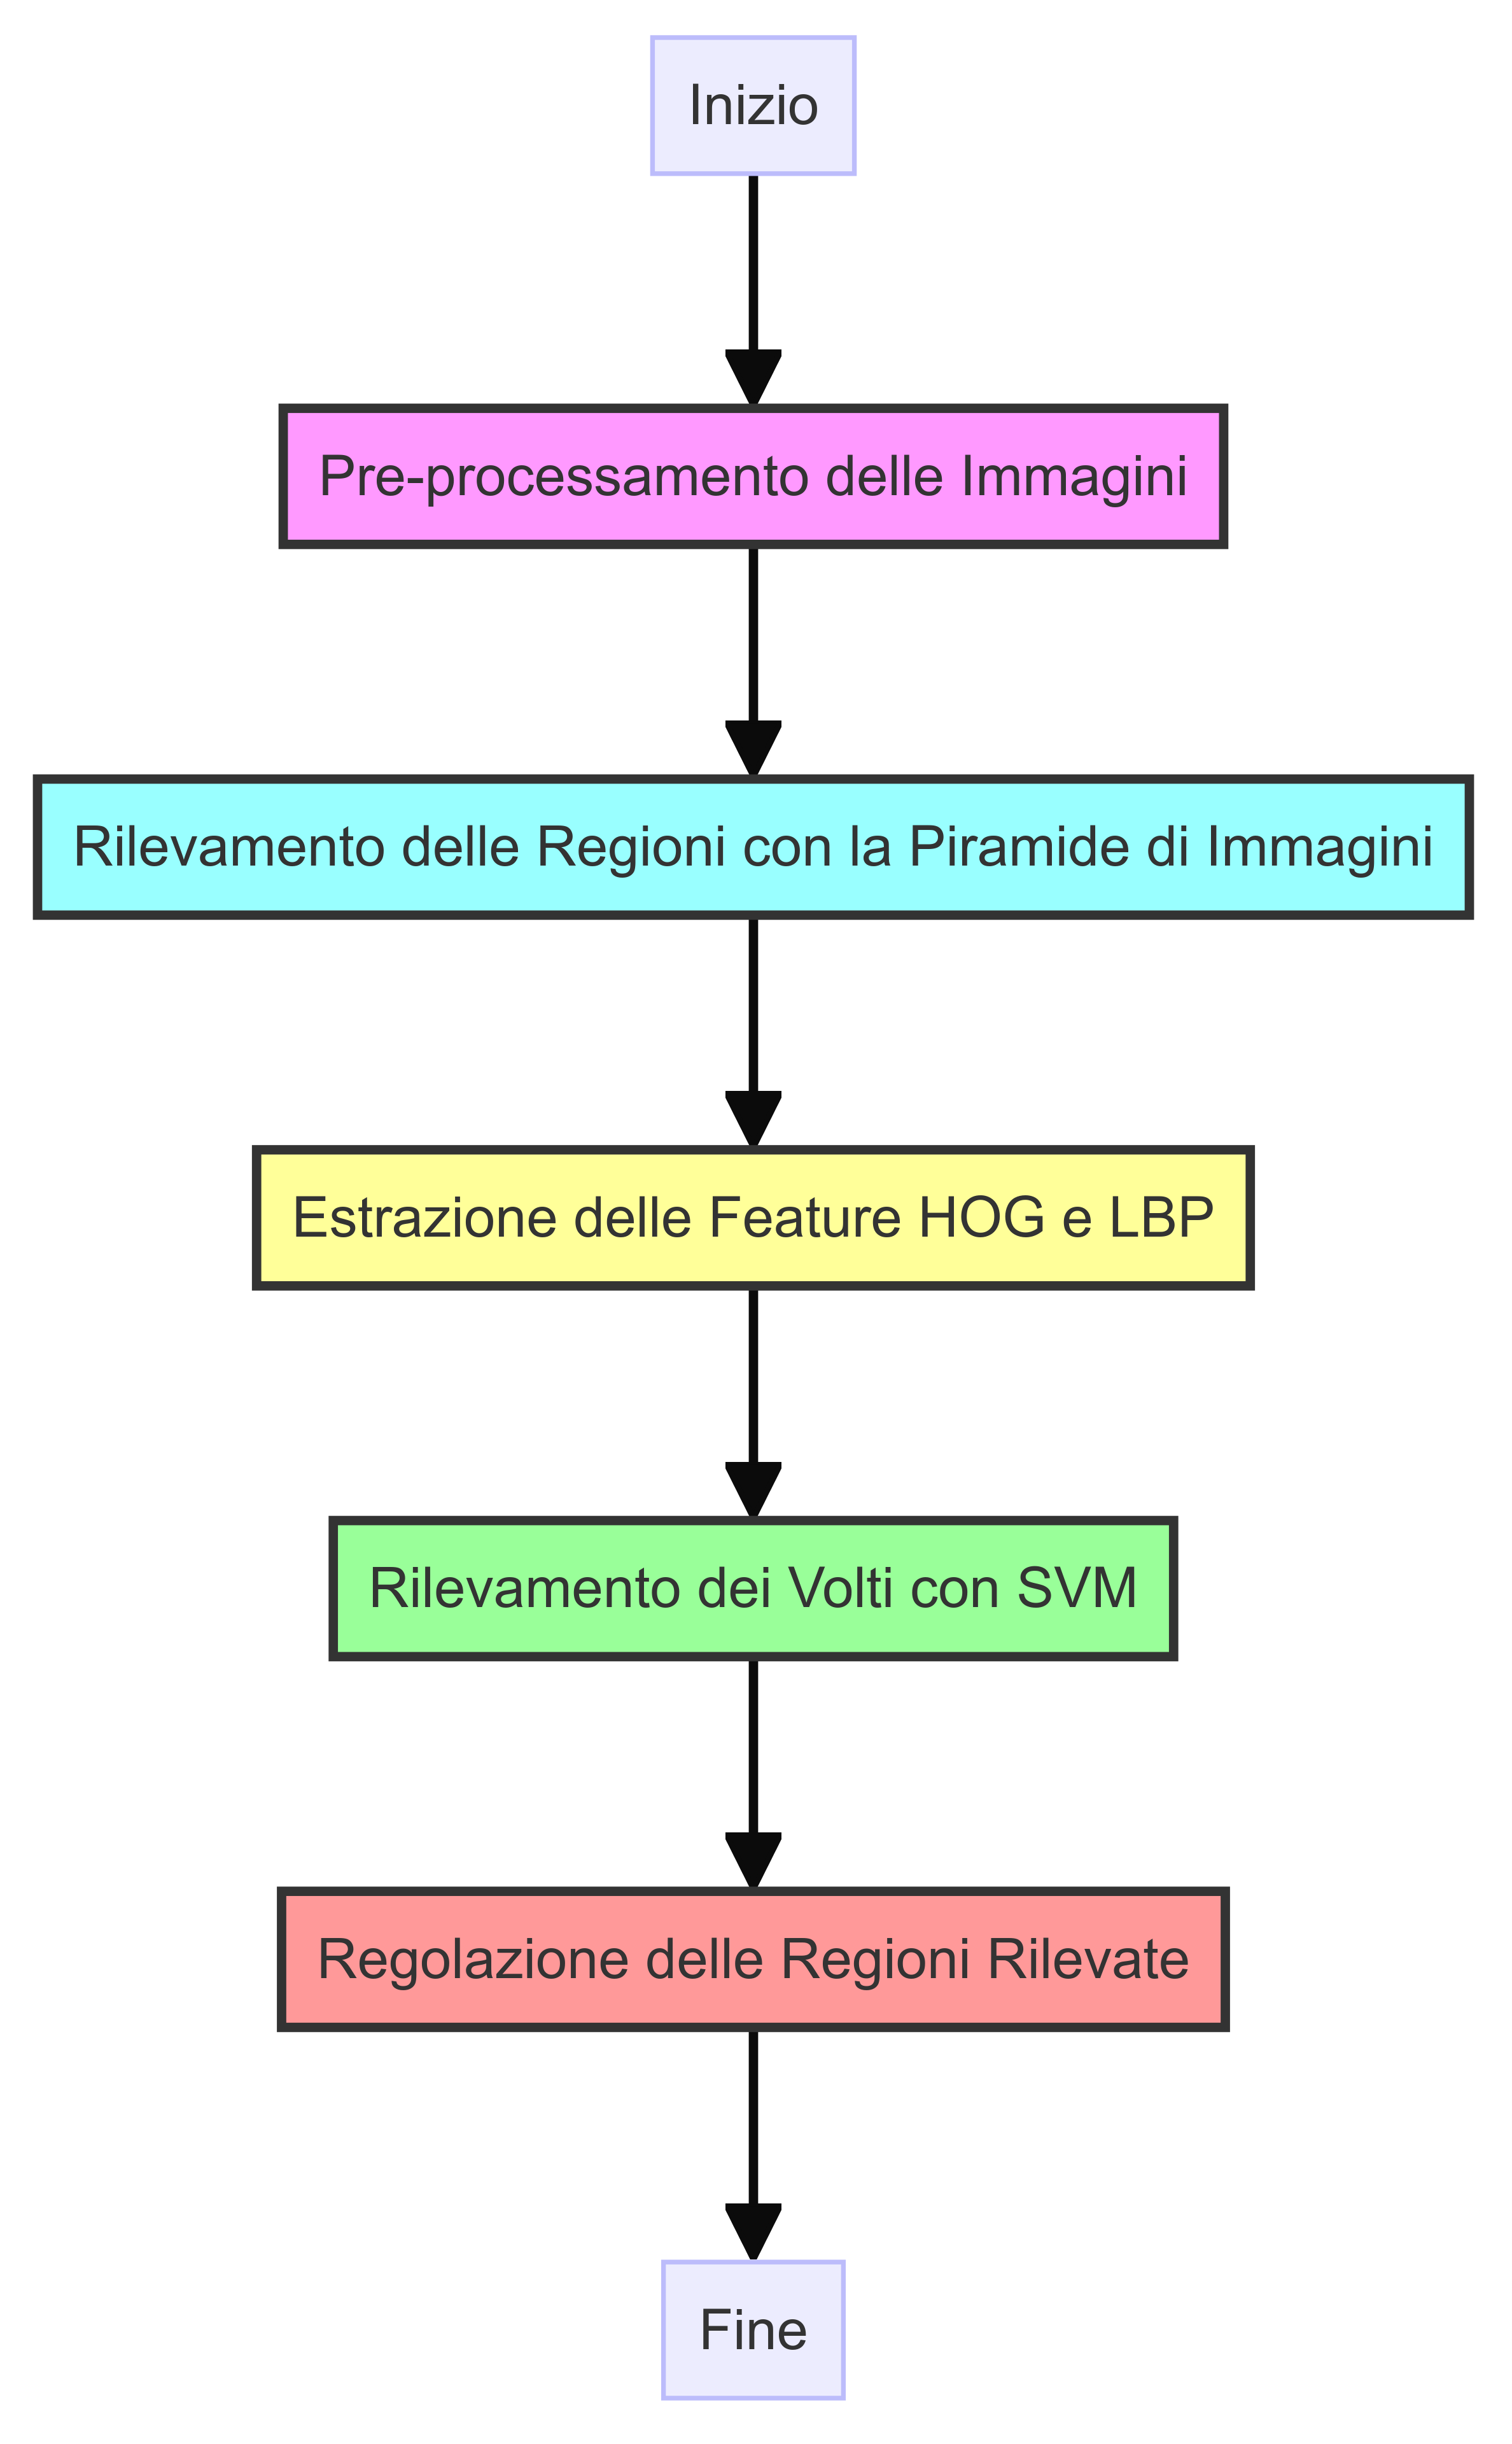

In [ ]:
# Definizione delle classi per la pipeline
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    """
    Una classe per il pre-processamento delle immagini prima del rilevamento dei volti.

    Questa classe ridimensiona le immagini mantenendo le proporzioni e le converte in scala di grigi.
    È progettata per funzionare con la pipeline di scikit-learn.

    Attributi:
    ----------
    max_size : int
        La dimensione massima (in pixel) per il lato più lungo dell'immagine ridimensionata.

    Metodi:
    -------
    fit(X, y=None):
        Adatta il preprocessore ai dati (operazione nulla per questa classe).
    transform(X):
        Applica il pre-processamento a una lista di immagini.
    resize_keeping_aspect_ratio(image):
        Ridimensiona una singola immagine mantenendo le sue proporzioni.
    """
    def __init__(self, max_size=512):
        self.max_size = max_size

    def fit(self, X, y=None):
        """
        Adatta il preprocessore ai dati.

        Parametri:
        ----------
        X : array-like
            I dati di input da adattare.
        y : array-like, opzionale
            Le etichette dei dati (non utilizzate in questo metodo).

        Ritorna:
        --------
        self : oggetto
            Ritorna l'istanza della classe.
        """
        return self

    def transform(self, X):
        """
        Applica il pre-processamento a una lista di immagini.

        Parametri:
        ----------
        X : lista di array-like
            Lista di immagini da pre-processare.

        Ritorna:
        --------
        processed : lista di tuple
            Lista di tuple contenenti l'immagine pre-processata, la dimensione originale e la dimensione ridimensionata.
        """
        processed = []
        for img in X:
            # Controlla se l'immagine è già in scala di grigi
            if img.ndim == 3:  # Se ha 3 dimensioni (canali colore), converte in scala di grigi
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img  # Se è già in scala di grigi, la mantiene così com'è
            resized = self.resize_keeping_aspect_ratio(gray)
            processed.append((resized, img.shape[:2], resized.shape[:2]))  # Include la dimensione originale e quella ridimensionata
        return processed

    def resize_keeping_aspect_ratio(self, image):
        """
        Ridimensiona una singola immagine mantenendo le sue proporzioni.

        Parametri:
        ----------
        image : array-like
            L'immagine da ridimensionare.

        Ritorna:
        --------
        resized : array-like
            L'immagine ridimensionata.
        """
        h, w = image.shape[:2]
        if h > w:
            new_h = self.max_size
            new_w = int(w * (self.max_size / h))
        else:
            new_w = self.max_size
            new_h = int(h * (self.max_size / w))

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return resized

class PyramidRegionDetector(BaseEstimator, TransformerMixin):
    """
    Una classe per rilevare regioni di interesse utilizzando un approccio a piramide di immagini.

    Questa classe crea una piramide di immagini e rileva regioni di interesse a multiple scale.
    È progettata per funzionare con la pipeline di scikit-learn.

    Attributi:
    ----------
    num_levels : int
        Il numero di livelli nella piramide di immagini.
    window_sizes : lista di tuple
        Le dimensioni delle finestre scorrevoli usate per il rilevamento.
    step_size : int
        La dimensione del passo per la finestra scorrevole.
    min_size : int
        La dimensione minima di un'immagine nella piramide.

    Metodi:
    -------
    fit(X, y=None):
        Adatta il rilevatore ai dati (operazione nulla per questa classe).
    transform(X):
        Applica il rilevamento delle regioni a una lista di immagini pre-processate.
    create_image_pyramid(image):
        Crea una piramide di immagini da una singola immagine.
    detect_regions_pyramid(image_pyramid):
        Rileva regioni di interesse su tutti i livelli della piramide di immagini.
    detect_regions(image, window_size):
        Rileva regioni di interesse in una singola immagine usando una finestra scorrevole.
    """
    def __init__(self, num_levels=5, window_sizes=[(40, 40), (60, 60), (80, 80)], step_size=16, min_size=20):
        self.num_levels = num_levels
        self.window_sizes = window_sizes
        self.step_size = step_size
        self.min_size = min_size

    def fit(self, X, y=None):
        """
        Adatta il rilevatore ai dati.

        Parametri:
        ----------
        X : array-like
            I dati di input da adattare.
        y : array-like, opzionale
            Le etichette dei dati (non utilizzate in questo metodo).

        Ritorna:
        --------
        self : oggetto
            Ritorna l'istanza della classe.
        """
        return self

    def transform(self, X):
        """
        Applica il rilevamento delle regioni a una lista di immagini pre-processate.

        Parametri:
        ----------
        X : lista di tuple
            Lista di tuple contenenti l'immagine pre-processata, la dimensione originale e la dimensione ridimensionata.

        Ritorna:
        --------
        lista di tuple
            Lista di tuple contenenti l'immagine pre-processata, la dimensione originale, la dimensione ridimensionata e le regioni rilevate.
        """
        all_regions = []
        for img, orig_size, resized_size in X:
            pyramid = self.create_image_pyramid(img)
            regions = self.detect_regions_pyramid(pyramid)
            all_regions.append(regions)
        return [(img, orig_size, resized_size, regions) for (img, orig_size, resized_size), regions in zip(X, all_regions)]

    def create_image_pyramid(self, image):
        """
        Crea una piramide di immagini da una singola immagine.

        Parametri:
        ----------
        image : array-like
            L'immagine di input.

        Ritorna:
        --------
        pyramid : lista di array-like
            Lista di immagini che formano la piramide.
        """
        pyramid = [image]
        for i in range(1, self.num_levels):
            next_level = cv2.pyrDown(pyramid[-1])
            if min(next_level.shape[:2]) < self.min_size:
                break
            pyramid.append(next_level)
        return pyramid

    def detect_regions_pyramid(self, image_pyramid):
        """
        Rileva regioni di interesse su tutti i livelli della piramide di immagini.

        Parametri:
        ----------
        image_pyramid : lista di array-like
            La piramide di immagini.

        Ritorna:
        --------
        all_regions : lista di tuple
            Lista di tutte le regioni rilevate in tutti i livelli della piramide.
        """
        all_regions = []
        for i, image in enumerate(image_pyramid):
            scale = 2 ** i
            for window_size in self.window_sizes:
                regions = self.detect_regions(image, window_size)
                scaled_regions = [(x * scale, y * scale, window_size[0] * scale, window_size[1] * scale) for (x, y, _) in regions]
                all_regions.extend(scaled_regions)
        return all_regions

    def detect_regions(self, image, window_size):
        """
        Rileva regioni di interesse in una singola immagine usando una finestra scorrevole.

        Parametri:
        ----------
        image : array-like
            L'immagine in cui rilevare le regioni.
        window_size : tuple
            Le dimensioni della finestra scorrevole.

        Ritorna:
        --------
        regions : lista di tuple
            Lista di tutte le regioni rilevate nell'immagine.
        """
        regions = []
        for y in range(0, image.shape[0] - window_size[1], self.step_size):
            for x in range(0, image.shape[1] - window_size[0], self.step_size):
                regions.append((x, y, image[y:y + window_size[1], x:x + window_size[0]]))
        return regions

class FaceDetector(BaseEstimator, TransformerMixin):
    """
    Una classe per rilevare volti nelle immagini utilizzando un classificatore pre-addestrato.

    Questa classe è progettata per funzionare con la pipeline di scikit-learn, ereditando da
    BaseEstimator e TransformerMixin. Utilizza un classificatore fornito per rilevare volti
    nelle regioni dell'immagine basandosi sulle caratteristiche estratte.

    Attributi:
    ----------
    classifier : oggetto
        Un classificatore pre-addestrato per il rilevamento dei volti.
    scaler : oggetto
        Un oggetto scaler per normalizzare le caratteristiche (attualmente non utilizzato).

    Metodi:
    -------
    fit(X, y=None):
        Adatta il rilevatore ai dati (in questo caso, è un'operazione nulla).
    transform(X):
        Trasforma i dati di input rilevando i volti in ciascuna immagine.
    non_max_suppression(boxes, overlap_thresh=0.3):
        Applica la soppressione non-massima per rimuovere i riquadri di delimitazione sovrapposti.
    """
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y=None):
        """
        Adatta il rilevatore ai dati.

        Parametri:
        ----------
        X : array-like
            I dati di input da adattare.
        y : array-like, opzionale
            Le etichette dei dati (non utilizzate in questo metodo).

        Ritorna:
        --------
        self : oggetto
            Ritorna l'istanza della classe.
        """
        return self

    def transform(self, X):
        """
        Trasforma i dati di input rilevando i volti in ciascuna immagine.

        Parametri:
        ----------
        X : lista di tuple
            Lista di tuple contenenti le caratteristiche, le regioni, la dimensione originale e la dimensione ridimensionata.

        Ritorna:
        --------
        detected_faces : lista di tuple
            Lista di tuple contenenti i volti rilevati, la dimensione originale e la dimensione ridimensionata.
        """
        detected_faces = []
        for features, regions, orig_size, resized_size in X:
            probabilities = self.classifier.predict(features)
            faces = [(x, y, x + w, y + h) for (x, y, w, h), prob in zip(regions, probabilities) if prob == 1]
            faces = self.non_max_suppression(faces)
            detected_faces.append((faces, orig_size, resized_size))
        return detected_faces

    def non_max_suppression(self, boxes, overlap_thresh=0.3):
        """
        Applica la soppressione non-massima per rimuovere i riquadri di delimitazione sovrapposti.

        Parametri:
        ----------
        boxes : array-like
            Array di riquadri di delimitazione.
        overlap_thresh : float, opzionale
            Soglia di sovrapposizione per la soppressione.

        Ritorna:
        --------
        array
            Array di riquadri di delimitazione dopo la soppressione non-massima.
        """
        if len(boxes) == 0:
            return []

        boxes = np.array(boxes)
        pick = []
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]
            idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

        return boxes[pick].astype("int")


class FaceAdjuster(BaseEstimator, TransformerMixin):
    """
    Una classe per regolare le regioni dei volti rilevati.

    Questa classe è progettata per funzionare con la pipeline di scikit-learn, ereditando da
    BaseEstimator e TransformerMixin. Regola le regioni dei volti rilevati aggiungendo
    del padding e assicurandosi che si adattino ai confini dell'immagine.

    Attributi:
    ----------
    padding : float
        La quantità di padding da aggiungere intorno alle regioni dei volti rilevati.

    Metodi:
    -------
    fit(X, y=None):
        Adatta il regolatore ai dati (in questo caso, è un'operazione nulla).
    transform(X):
        Trasforma i dati di input regolando le regioni dei volti rilevati.
    adjust_rectangle(rect, original_shape):
        Regola un singolo rettangolo (regione del volto) aggiungendo padding e adattandolo all'immagine.
    """
    def __init__(self, padding=0.5):
        self.padding = padding

    def fit(self, X, y=None):
        """
        Adatta il regolatore ai dati.

        Parametri:
        ----------
        X : array-like
            I dati di input da adattare.
        y : array-like, opzionale
            Le etichette dei dati (non utilizzate in questo metodo).

        Ritorna:
        --------
        self : oggetto
            Ritorna l'istanza della classe.
        """
        return self

    def transform(self, X):
        """
        Trasforma i dati di input regolando le regioni dei volti rilevati.

        Parametri:
        ----------
        X : lista di tuple
            Lista di tuple contenenti i volti rilevati, la dimensione originale e la dimensione ridimensionata.

        Ritorna:
        --------
        adjusted_faces : lista di liste
            Lista di liste contenenti le regioni dei volti regolate per ciascuna immagine.
        """
        adjusted_faces = []
        for faces, orig_size, resized_size in X:
            h_orig, w_orig = orig_size
            h_resized, w_resized = resized_size
            scale_x, scale_y = w_orig / w_resized, h_orig / h_resized

            adjusted = []
            for (x1, y1, x2, y2) in faces:
                rect = (int(x1 * scale_x), int(y1 * scale_y),
                        int((x2 - x1) * scale_x), int((y2 - y1) * scale_y))
                adjusted_rect = self.adjust_rectangle(rect, orig_size)
                adjusted.append(adjusted_rect)

            adjusted_faces.append(adjusted)
        return adjusted_faces

    def adjust_rectangle(self, rect, original_shape):
        """
        Regola un singolo rettangolo (regione del volto) aggiungendo padding e adattandolo all'immagine.

        Parametri:
        ----------
        rect : tuple
            Tuple contenente le coordinate (x, y, x1, y1) del rettangolo da regolare.
        original_shape : tuple
            Tuple contenente le dimensioni (altezza, larghezza) dell'immagine originale.

        Ritorna:
        --------
        tuple
            Tuple contenente le coordinate (x, y, x1, y1) del rettangolo regolato.
        """
        x, y, w, h = rect

        # Aggiunge padding
        pad_x = w * self.padding
        pad_y = h * self.padding
        x -= pad_x / 2
        y -= pad_y / 2
        w += pad_x
        h += pad_y

        # Assicura che il rettangolo sia all'interno dei confini dell'immagine
        x = max(0, x)
        y = max(0, y)
        w = min(original_shape[1] - x, w)
        h = min(original_shape[0] - y, h)

        return (int(x), int(y), int(x + w), int(y + h))

In questo stralcio di codice, presento l'implementazione e l'utilizzo di una pipeline per il rilevamento dei volti nelle immagini.

Ho definito una funzione `detect_faces` che applica la pipeline a un'immagine di input e, opzionalmente, visualizza i risultati. La pipeline stessa è costruita utilizzando le classi che ho precedentemente implementato: `ImagePreprocessor`, `PyramidRegionDetector`, `FeatureExtractor`, `FaceDetector`, e `FaceAdjuster`.

Queste classi lavorano in sequenza per preprocessare l'immagine, rilevare potenziali regioni di interesse, estrarre caratteristiche, identificare i volti e infine regolare le regioni rilevate.

Ho incluso anche un esempio di utilizzo che dimostra come applicare la pipeline a un'immagine specifica e visualizzare i risultati.

Questo codice rappresenta un'applicazione pratica delle tecniche di computer vision e machine learning per affrontare il problema del rilevamento dei volti, mostrando come diverse componenti possano essere integrate in un sistema funzionale.

Immagine caricata correttamente. Dimensioni: (1366, 2048, 3)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


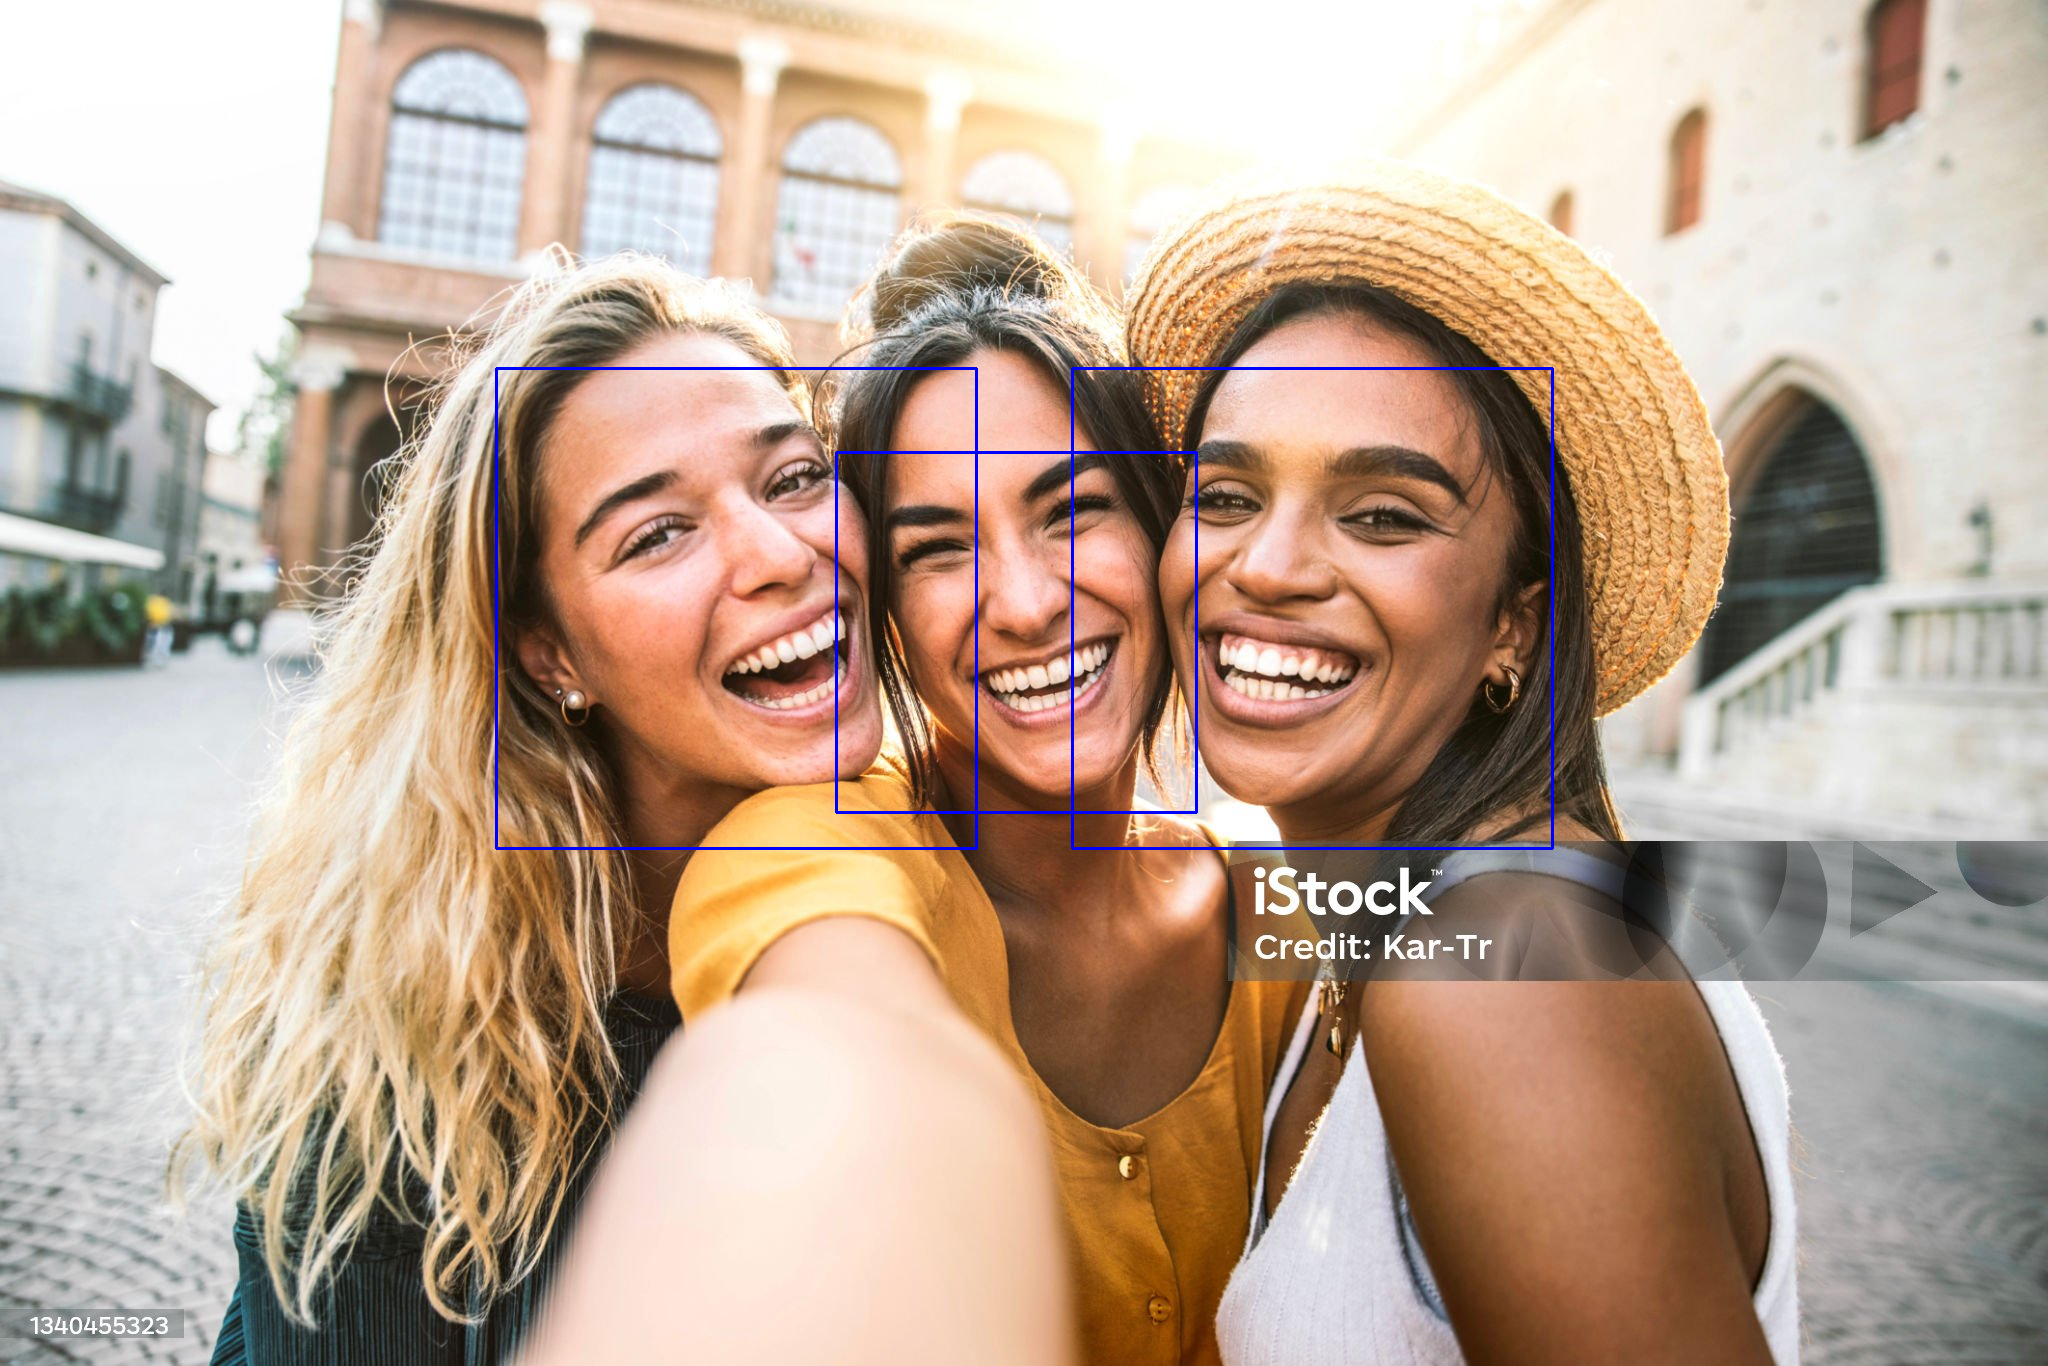

Detected faces: 3


In [ ]:
import requests

# Uso della pipeline
def detect_faces(image_path, pipeline, visualize = True):
    if image_path.startswith('http'):
        # Scarica l'immagine usando requests
        response = requests.get(image_path)
        if response.status_code != 200:
            print(f"Errore nel download dell'immagine. Codice di stato: {response.status_code}")
            return None, []

        # Converte i dati dell'immagine in un array numpy
        image_array = np.frombuffer(response.content, np.uint8)

        # Decodifica l'array in un'immagine
        original_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        if original_image is None:
            print("Impossibile decodificare l'immagine scaricata.")
            return None, []
    else:
        # Se non è un URL, prova a leggere l'immagine come file locale
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Impossibile leggere l'immagine dal percorso: {image_path}")
            return None, []

    print(f"Immagine caricata correttamente. Dimensioni: {original_image.shape}")

    # La pipeline si aspetta una lista di immagini
    adjusted_faces = pipeline.transform([original_image])[0]

    if visualize:
      # Disegno dei risultati
      result_image = original_image.copy()
      for (x, y, x1, y1) in adjusted_faces:
          cv2.rectangle(result_image, (x, y), (x1, y1), (255, 0, 0), 2)

      return result_image, adjusted_faces
    else:
      return adjusted_faces




face_detection_pipeline = Pipeline([
    ('preprocessor', ImagePreprocessor()),
    ('region_detector', PyramidRegionDetector()),
    ('feature_extractor', FeatureExtractor()),
    ('face_detector', FaceDetector(classifier)),  # 'classifier' è il tuo classificatore pre-addestrato
    ('face_adjuster', FaceAdjuster())
])

# Esempio di utilizzo
image_path = '/content/istockphoto-1340455323-2048x2048.jpg'
result_image, detected_faces = detect_faces(image_path, face_detection_pipeline)
cv2_imshow(result_image)
print(f"Detected faces: {len(detected_faces)}")

#Step 5 - Salvataggio modello


In questo frammento di codice, illustro il salvataggio della pipeline di rilevamento dei volti.

Ho implementato una funzione `save_pipeline` che utilizza la libreria `joblib` per serializzare l'intera pipeline e salvarla su Google Drive.

Questo approccio è fondamentale per preservare il modello addestrato e la configurazione della pipeline, consentendo un facile riutilizzo e distribuzione.

La funzione accetta come parametri la pipeline da salvare e il nome del file, costruisce il percorso completo su Google Drive e procede al salvataggio.

In [ ]:
# Metodo per il salvataggio della pipeline su Google Drive
def save_pipeline(pipeline, filename):
    # Definisci il percorso di salvataggio su Google Drive
    save_path = '/content/drive/MyDrive/Colab Notebooks/'
    full_path = os.path.join(save_path, filename)

    # Salva la pipeline
    joblib.dump(pipeline, full_path)
    print(f"Pipeline salvata come {full_path}")

# salvataggio della pipeline da Google Drive
save_pipeline(face_detection_pipeline, 'face_detection_pipeline.joblib')

Pipeline salvata come /content/drive/MyDrive/Colab Notebooks/face_detection_pipeline.joblib


#Step 6 - Caricamento ed esecuzione modello

In questo pezzo di codice, mostro come ricaricare la pipeline di rilevamento volti che ho salvato prima su Google Drive. Ho creato una funzione chiamata load_pipeline che fa tutto il lavoro. Questa funzione cerca il file salvato su Google Drive, lo apre e ricrea la pipeline esattamente come era prima. È come riprendere il lavoro da dove l'avevo lasciato, senza dover rifare tutto da capo. Alla fine, mostro anche come usare questa funzione per caricare la pipeline che avevo salvato prima. Questo mi permette di riutilizzare facilmente il mio modello di rilevamento volti in qualsiasi momento, senza dover riaddestrare tutto ogni volta.

In [ ]:
# Caricamento della pipeline da Google Drive
def load_pipeline(filename):
    # Definisci il percorso di caricamento da Google Drive
    load_path = '/content/drive/MyDrive/Colab Notebooks/'
    full_path = os.path.join(load_path, filename)

    # Carica la pipeline
    pipeline = joblib.load(full_path)
    print(f"Pipeline caricata da {full_path}")
    return pipeline

pipeline = load_pipeline('face_detection_pipeline.joblib')

Pipeline caricata da /content/drive/MyDrive/Colab Notebooks/face_detection_pipeline.joblib


## Esecuzione pipeline con visualizzazione

In questa parte del codice, mostro come utilizzare la pipeline di rilevamento volti su immagini caricate dall'utente. Prima di tutto, uso la funzione `files.upload()` per permettere all'utente di caricare una o più immagini. Poi, per ogni immagine caricata, faccio due cose importanti:

- Uso la funzione detect_faces che ho creato prima per trovare i volti nell'immagine.
- Mostro l'immagine con i volti evidenziati e stampo il numero di volti trovati.

Saving istockphoto-1340455323-2048x2048.jpg to istockphoto-1340455323-2048x2048 (5).jpg
Elaborazione di istockphoto-1340455323-2048x2048 (5).jpg...
Immagine caricata correttamente. Dimensioni: (1366, 2048, 3)


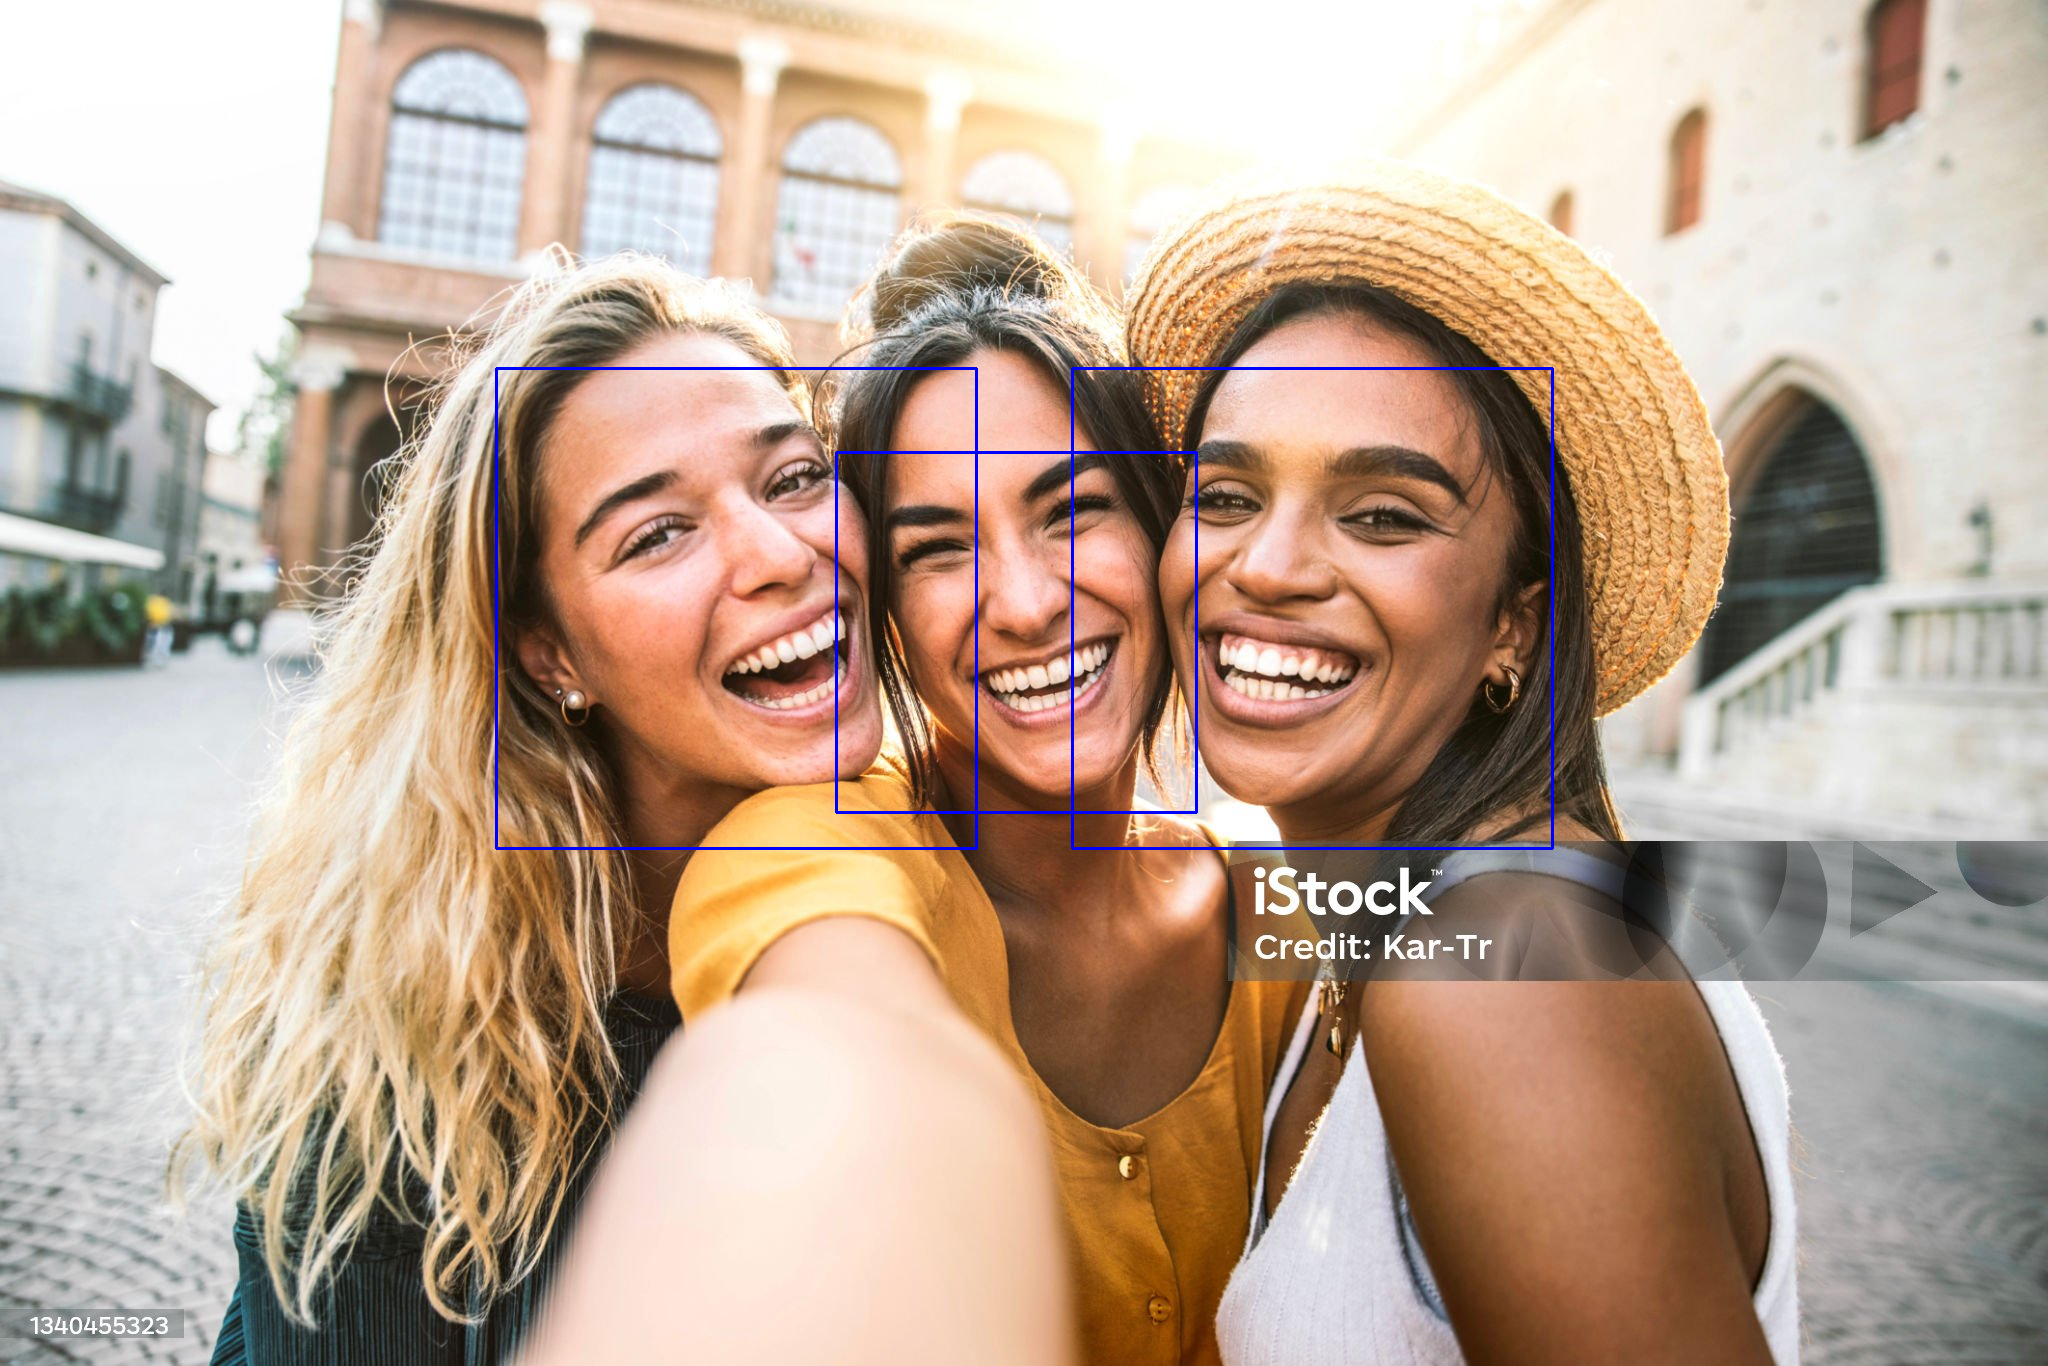

Detected faces: 3


In [ ]:
# Upload del file e processamento
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Elaborazione di {filename}...")
    result_image, detected_faces = detect_faces(filename, pipeline, True)
    cv2_imshow(result_image)
    print(f"Detected faces: {len(detected_faces)}")

## Esecuzione pipeline con bounding box
In questa parte del codice, mostro una variante del processo di rilevamento volti su immagini caricate dall'utente. Come prima, uso `files.upload()` per permettere all'utente di caricare immagini. La differenza principale è nel modo in cui uso la funzione detect_faces:

Chiamo detect_faces con il parametro visualize impostato su False.
Invece di mostrare l'immagine, stampo direttamente le coordinate dei volti rilevati.

Questo approccio è utile quando voglio solo le informazioni sui volti rilevati, senza visualizzare l'immagine.

In [ ]:
# Upload del file e processamento
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Elaborazione di {filename}...")
    detected_faces = detect_faces(filename, pipeline, False)
    print(f"Detected faces count: {len(detected_faces)}")
    print(f"Detected faces coordinates: {detected_faces}")

Saving istockphoto-1340455323-2048x2048.jpg to istockphoto-1340455323-2048x2048 (6).jpg
Elaborazione di istockphoto-1340455323-2048x2048 (6).jpg...
Immagine caricata correttamente. Dimensioni: (1366, 2048, 3)
Detected faces count: 3
Detected faces coordinates: [(1072, 368, 1552, 848), (496, 368, 976, 848), (836, 452, 1196, 812)]


# Note finali
## Possibili migliorie future

La pipeline di rilevamento volti attuale offre buone prestazioni, ma ci sono diverse aree in cui potrebbe essere ulteriormente migliorata:

## 1. Ottimizzazione computazionale
- **Bilanciamento algoritmi**: La pipeline può essere ottimizzata bilanciando meglio le impostazioni tra i vari algoritmi, in particolare HOG (Histogram of Oriented Gradients) e LBP (Local Binary Patterns).
- **Parallelizzazione**: Implementare tecniche di elaborazione parallela per sfruttare meglio le risorse hardware disponibili.
- **Uso di GPU**: Adattare parti dell'algoritmo per l'esecuzione su GPU, potenzialmente accelerando significativamente il processo.

## 2. Scelta e ottimizzazione del modello
- **Valutazione approfondita**: Sebbene l'SVM (Support Vector Machine) sia stato scelto per il suo buon equilibrio tra tempo di elaborazione e prestazioni, una valutazione più approfondita potrebbe rivelare alternative migliori.
- **Confronto sistematico**: Eseguire un confronto sistematico tra SVM, Random Forest, e altri modelli come Reti Neurali Convoluzionali (CNN), utilizzando metriche standardizzate.
- **Iperparametri**: Ottimizzare gli iperparametri del modello scelto attraverso tecniche come la ricerca a griglia o l'ottimizzazione bayesiana.

## 3. Ottimizzazione della piramide di immagini e della sliding window
- **Bilanciamento scale**: Sperimentare con diverse configurazioni della piramide di immagini per trovare il miglior compromesso tra copertura e tempo di elaborazione.
- **Dimensioni finestra**: Ottimizzare le dimensioni e il passo della sliding window per migliorare sia la precisione che l'efficienza.
- **Approccio adattivo**: Implementare un approccio adattivo che regoli dinamicamente i parametri della piramide e della finestra in base alle caratteristiche dell'immagine.

## 4. Miglioramento della robustezza
- **Variazioni di illuminazione**: Implementare tecniche di normalizzazione dell'illuminazione per migliorare le prestazioni in condizioni di illuminazione variabile.
- **Occlusioni parziali**: Sviluppare metodi per gestire meglio i casi di occlusione parziale del volto.
- **Pose non frontali**: Migliorare il rilevamento di volti in pose non frontali, possibilmente utilizzando modelli multi-view.

## 5. Espansione delle funzionalità
- **Riconoscimento di attributi**: Aggiungere la capacità di riconoscere attributi facciali come età, genere, espressione emotiva.
- **Tracciamento**: Implementare il tracciamento dei volti in sequenze video per migliorare l'efficienza e la coerenza temporale.
- **Integrazione di profondità**: Per applicazioni che utilizzano sensori di profondità, incorporare informazioni 3D per migliorare l'accuratezza del rilevamento.

Queste migliorie potrebbero significativamente aumentare le prestazioni, l'accuratezza e la versatilità della pipeline di rilevamento volti, rendendola più adatta a una gamma più ampia di applicazioni e scenari d'uso.